# Unsupervised Machine Learning (USArrests)

**Student:** Ntokozo Mazibuko  
**Dataset:** UsArrests.csv (50 US states, 1973)

## My Plan for the Task
- First, I’ll explore the dataset and explain why I clean or scale certain columns.  
- Next, I want to see how the features relate to each other using correlations.  
- Then I’ll apply PCA on the scaled data and look at a biplot (PC1 vs PC2) to understand the structure.  
- I’ll decide how many components are enough by looking at variance explained and my own reasoning.  
- Finally, I’ll try two clustering approaches (KMeans and Agglomerative) and compare what they show.

> Why this order? Scaling/correlation informs PCA; PCA gives a compact view that often improves clustering geometry.

## Library Imports and Configuration

To begin the analysis, I imported essential libraries for numerical computation, data handling, visualization, and clustering. This includes tools from numpy, pandas, matplotlib, and scikit-learn, along with system utilities and type annotations for cleaner code structure.

Key configurations:
* Reproducibility: A fixed random seed (SEED = 42) ensures consistent results across runs.
* Plotting defaults: Matplotlib settings are adjusted for better readability, with a standard figure size and grid enabled.
* Data source: The dataset is expected to be located at 'UsArrests.csv', referenced using a Path object for portability.

This setup prepares the environment for data exploration, preprocessing, and clustering workflows.


---
Reflection: I’m structuring the work this way because it helps me move step by step: clean → reduce → cluster. This keeps my workflow logical and avoids confusion later.

In [12]:
# Bringing in the Python libraries I'll need for this task

import math
import sys
from pathlib import Path
from typing import Tuple, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display 
from __future__ import annotations

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Fixing the random seed so my results don't change each time I run the notebook
SEED: int = 42
np.random.seed(SEED)

# Setting some default plot styles so visuals are easier to read
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True

# Pointing to where my dataset is stored
DATA_PATH = Path('UsArrests.csv')


# Modular Helper Functions for Clustering Workflow

This section defines a set of reusable, testable functions to support the full clustering pipeline—from data loading and preprocessing to dimensionality reduction and evaluation. Each function is designed to be standalone and easy to integrate into notebooks or scripts.

# Data Handling
- load_us_arrests(path): Loads the USArrests dataset with flexible filename matching and optional state indexing. Includes basic validation to ensure expected columns are present.
- numeric_summary(df): Generates a tidy summary of numeric columns, including missing value counts and distributional stats.

# Preprocessing
- zscore_scale(df_numeric): Applies z-score standardization to numeric features, returning both the scaled DataFrame and the fitted scaler.

# Exploratory Analysis
- plot_correlation(df_numeric): Visualizes feature correlations using a heatmap built with matplotlib.

# Dimensionality Reduction
- fit_pca(df_scaled, n_components): Fits PCA to standardized data and returns both the model and a DataFrame of principal component scores.
- scree_plot(pca): Displays variance explained per component and cumulative variance to guide dimensionality choices.
- biplot(pcs, pca, features): Creates a PC1 vs PC2 scatter plot with feature loading arrows for interpretability.

# Clustering Evaluation
- kmeans_sweep(X, k_min, k_max): Runs KMeans across a range of cluster counts, capturing inertia and silhouette scores for each.
- plot_elbow_silhouette(results): Visualizes the elbow method and silhouette scores to help select an optimal k.
- cluster_summary(df_original, labels, label_name): Aggregates cluster-wise means on the original scale for interpretability.

These helpers streamline the analysis and make the notebook more maintainable and transparent.


In [13]:
# Helper Functions — Modular and Reusable
def load_us_arrests(path: Path) -> pd.DataFrame:
    # Accept common filename variants to improve flexibility
    candidates = [path, Path('USArrests.csv'), Path('UsArrests.csv'), Path('usarrests.csv')]
    csv_path = next((p for p in candidates if p.exists()), None)

    # Raise an error if no valid file is found
    if csv_path is None:
        raise FileNotFoundError(
            'Could not find UsArrests.csv. Place it next to the notebook or update DATA_PATH.'
        )
    # Read the CSV into a DataFrame    
    df = pd.read_csv(csv_path)

   # Promote state names to index if a suitable column is found
    state_col = None
    for c in df.columns:
        if str(c).strip().lower() in ('unnamed: 0', 'state'):
            state_col = c
            break
    if state_col is not None:
        df = df.set_index(state_col)

    # Defensive checks
    expected_like = {'murder', 'assault', 'urbanpop', 'rape'}
    lower_cols = {c.lower() for c in df.columns}
    if not expected_like.issubset(lower_cols):
        print('Warning: unexpected columns detected. Proceeding, but check the CSV header.', file=sys.stderr)

    return df

# Generate a summary of numeric columns, including missing values.
def numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    num_df = df.select_dtypes(include=[np.number]).copy()
    summary = num_df.describe().T
    summary['missing'] = num_df.isna().sum()
    summary['pct_missing'] = (summary['missing'] / len(num_df)).round(3)
    return summary

# Standardize numeric features to mean 0 and variance 1.
def zscore_scale(df_numeric: pd.DataFrame) -> Tuple[pd.DataFrame, StandardScaler]:
    scaler = StandardScaler()
    arr = scaler.fit_transform(df_numeric.values)
    scaled = pd.DataFrame(arr, columns=df_numeric.columns, index=df_numeric.index)
    return scaled, scaler

# Visualize feature correlations using a heatmap.
def plot_correlation(df_numeric: pd.DataFrame) -> None:
    corr = df_numeric.corr(numeric_only=True)
    fig, ax = plt.subplots()
    cax = ax.imshow(corr.values, interpolation='nearest')
    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha='right')
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)
    fig.colorbar(cax)
    ax.set_title('Correlation heatmap')
    fig.tight_layout()
    plt.show()

# Apply PCA to scaled data and return the model and transformed scores.
def fit_pca(df_scaled: pd.DataFrame, n_components: Optional[int] = None) -> Tuple[PCA, pd.DataFrame]:
    pca = PCA(n_components=n_components, random_state=SEED)
    scores = pca.fit_transform(df_scaled.values)
    pcs = pd.DataFrame(scores,
                       index=df_scaled.index,
                       columns=[f'PC{i+1}' for i in range(scores.shape[1])])
    return pca, pcs

# Plot variance explained by each principal component.
def scree_plot(pca: PCA) -> None:
    ratios = pca.explained_variance_ratio_
    xs = np.arange(1, len(ratios) + 1)

    # Plot individual component variance
    plt.figure()
    plt.plot(xs, ratios, marker='o')
    plt.xticks(xs)
    plt.xlabel('Principal component')
    plt.ylabel('Variance explained ratio')
    plt.title('Scree plot (per-component variance)')
    plt.tight_layout()
    plt.show()

    # Plot cumulative variance
    plt.figure()
    plt.plot(xs, np.cumsum(ratios), marker='o')
    plt.xticks(xs)
    plt.xlabel('Principal component')
    plt.ylabel('Cumulative variance explained')
    plt.title('Cumulative variance explained')
    plt.tight_layout()
    plt.show()


# Create a biplot showing samples and feature loadings in PC1–PC2 space.
def biplot(pcs: pd.DataFrame, pca: PCA, features: pd.Index, scale_arrows: float = 2.5) -> None:
    if pcs.shape[1] < 2:
        raise ValueError('Need at least 2 PCs for a biplot.')

    # extract the scores
    x = pcs['PC1'].values
    y = pcs['PC2'].values

    #plot sample points
    plt.figure()
    plt.scatter(x, y)
    for i, label in enumerate(pcs.index):
        plt.annotate(label, (x[i], y[i]), fontsize=8, alpha=0.7)

    # Plot feature loadings as arrows
    loadings = pca.components_[0:2, :].T  # shape: (n_features, 2)
    for i, feat in enumerate(features):
        plt.arrow(0, 0, loadings[i, 0]*scale_arrows, loadings[i, 1]*scale_arrows,
                  head_width=0.05, length_includes_head=True)
        plt.text(loadings[i, 0]*scale_arrows*1.1,
                 loadings[i, 1]*scale_arrows*1.1, feat, fontsize=9)

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Biplot: PC1 vs PC2 with feature loadings')
    plt.axhline(0, linewidth=1)
    plt.axvline(0, linewidth=1)
    plt.tight_layout()
    plt.show()

# Run KMeans for a range of k values and record inertia and silhouette scores.
def kmeans_sweep(X: pd.DataFrame, k_min: int = 2, k_max: int = 8) -> pd.DataFrame:
    """Compute inertia and silhouette over a sweep of k for KMeans."""
    rows = []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, n_init=20, random_state=SEED)
        labels = km.fit_predict(X.values)
        inertia = km.inertia_
        sil = silhouette_score(X.values, labels) if k > 1 else np.nan
        rows.append({'k': k, 'inertia': inertia, 'silhouette': sil})
    return pd.DataFrame(rows)

#lot elbow and silhouette scores to help choose optimal k.
def plot_elbow_silhouette(results: pd.DataFrame) -> None:
    
    # Elbow
    plt.figure()
    plt.plot(results['k'], results['inertia'], marker='o')
    plt.xticks(results['k'])
    plt.xlabel('k')
    plt.ylabel('KMeans inertia')
    plt.title('Elbow method (inertia vs k)')
    plt.tight_layout()
    plt.show()

    # Silhouette plot that shows cluster separation quality
    plt.figure()
    plt.plot(results['k'], results['silhouette'], marker='o')
    plt.xticks(results['k'])
    plt.xlabel('k')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette score vs k')
    plt.tight_layout()
    plt.show()

#Summarize cluster-wise feature means for interpretation
def cluster_summary(df_original: pd.DataFrame, labels: pd.Series, label_name: str) -> pd.DataFrame:
    """Aggregate cluster-wise means on original scale (readable interpretation)."""
    out = df_original.copy()
    out[label_name] = labels.values
    return out.groupby(label_name).mean(numeric_only=True).round(2)
# onfirm helper functions are ready to use
print("Helpers ready: load_us_arrests, numeric_summary, zscore_scale, fit_pca, scree_plot, biplot, kmeans_sweep, plot_elbow_silhouette, cluster_summary")


Helpers ready: load_us_arrests, numeric_summary, zscore_scale, fit_pca, scree_plot, biplot, kmeans_sweep, plot_elbow_silhouette, cluster_summary


# Load Dataset and Perform Initial Checks

- I began by loading the *USArrests* dataset using a custom helper function that handles common filename variations and promotes state names to the index if available. Once loaded, I previewed the shape and the first few rows to confirm the structure.

- To better understand the dataset, I generated a numeric summary that includes basic statistics (mean, standard deviation, quartiles) along with missing value counts and percentages.

As a final sanity check, I verified whether the dataset contains any missing values or duplicate rows. These quick validations help ensure the data is clean and ready for preprocessing.


In [14]:
# Load the dataset and perform basic exploratory checks

# Writing small helper functions to avoid repeating code later
df_raw = load_us_arrests(DATA_PATH)
# Print the shape of the dataset (rows x columns)
print(f'Shape: {df_raw.shape}')
# 
display(df_raw.head())

summary = numeric_summary(df_raw)
display(summary)

# Quick sanity checks
print('\nAny missing values?', df_raw.isna().any().any())
print('Any duplicate rows?', df_raw.duplicated().any())


Shape: (50, 5)


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


,count,mean,std,min,25%,50%,75%,max,missing,pct_missing
Murder,50.0,7.788,4.355510,0.8,4.075,7.25,11.250,17.4,0,0.0
Assault,50.0,170.760,83.337661,45.0,109.000,159.00,249.000,337.0,0,0.0
UrbanPop,50.0,65.540,14.474763,32.0,54.500,66.00,77.750,91.0,0,0.0
Rape,50.0,21.232,9.366385,7.3,15.075,20.10,26.175,46.0,0,0.0



Any missing values? False
Any duplicate rows? False


# Correlation Analysis of Numeric Features

To explore relationships between variables in the USArrests dataset, I extracted the numeric columns and computed a correlation matrix. This matrix quantifies how strongly each pair of features is linearly related, with values ranging from –1 (perfect negative correlation) to +1 (perfect positive correlation).

The matrix was rounded to three decimal places for clarity and then visualized using a heatmap-style plot. This helps identify patterns that might influence clustering or dimensionality reduction later.

# Key Observations:
- Murder and Assault show a strong positive correlation, suggesting that states with higher murder rates often also report higher assault rates.
- UrbanPop has a moderate positive correlation with Rape, but weaker ties to the other features.
- Rape is moderately correlated with both Murder and Assault, indicating some shared variance but not perfect alignment.

These relationships hint at underlying social or demographic factors and help justify the use of PCA to reduce redundancy before clustering.


,Murder,Assault,UrbanPop,Rape
Murder,1.000,0.802,0.070,0.564
Assault,0.802,1.000,0.259,0.665
UrbanPop,0.070,0.259,1.000,0.411
Rape,0.564,0.665,0.411,1.000


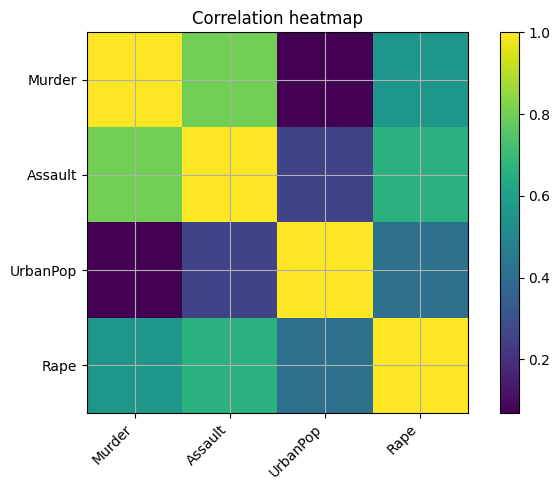

In [15]:
# Correlation analysis
num_df = df_raw.select_dtypes(include=[np.number]).copy()
corr = num_df.corr(numeric_only=True).round(3)
display(corr)
plot_correlation(num_df)



# Standardization and Principal Component Analysis (PCA)

To prepare the data for dimensionality reduction, I applied z-score standardization to the numeric features. This transformation ensures that each variable has a mean of zero and unit variance, preventing features with larger scales from dominating the PCA results.

Next, I fit PCA to the scaled data, extracting all available components. PCA transforms the original features into a new set of orthogonal axes (principal components) that capture the maximum variance in the dataset.

# Explained Variance:
I created a summary table showing:
- The variance ratio for each principal component (how much information it captures)
- The cumulative variance, which helps determine how many components are needed to retain most of the dataset’s structure

# The  scree plot visualizes these values:
- The first component explains the largest portion of variance
- Subsequent components contribute less, with diminishing returns
- A noticeable "elbow" in the plot suggests a natural cutoff point for dimensionality reduction

This step helps simplify the dataset while preserving its most informative patterns—ideal for clustering and visualization.


,PC,Variance_Ratio,Cumulative
0,PC1,0.6201,0.6201
1,PC2,0.2474,0.8675
2,PC3,0.0891,0.9566
3,PC4,0.0434,1.0000


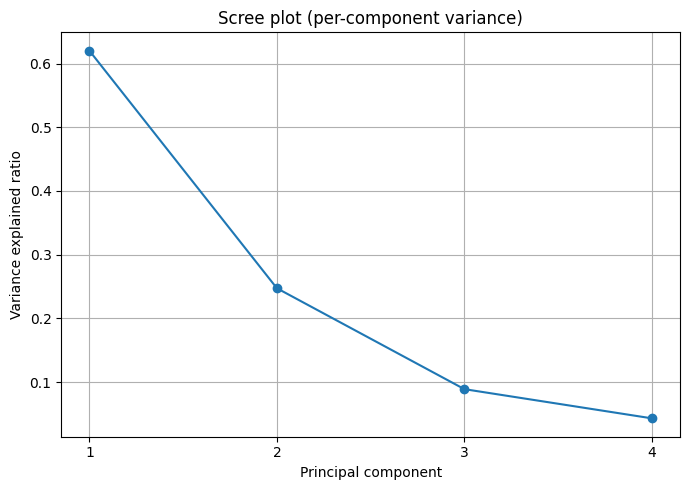

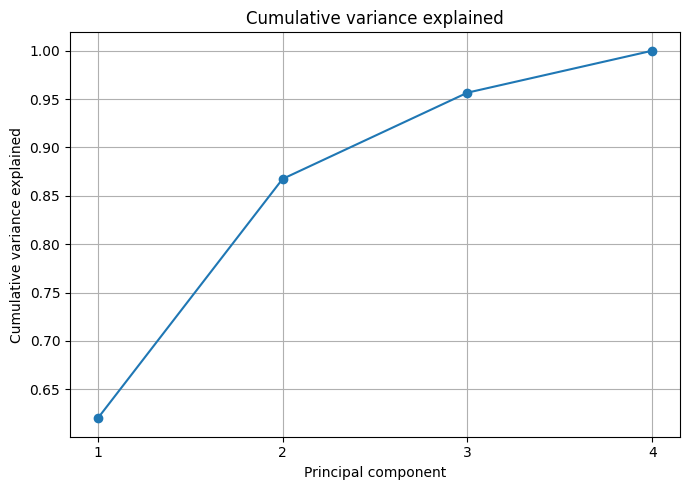

In [16]:
# Standardise and fit pca
scaled, scaler = zscore_scale(num_df)
pca, pcs = fit_pca(scaled)  # all components

# Variance explained
explained = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Variance_Ratio': pca.explained_variance_ratio_.round(4),
    'Cumulative': np.cumsum(pca.explained_variance_ratio_).round(4)
})
display(explained)

scree_plot(pca)


# Biplot of Principal Components (PC1 vs PC2)

To visually interpret the PCA results, I created a biplot using the first two principal components. Each point in the plot represents a state, projected into the reduced feature space defined by PC1 and PC2. This helps reveal patterns and groupings that may not be obvious in the original dimensions.

In addition to the scatter of samples, I overlaid arrows that represent the loadings—how strongly each original feature contributes to the principal components. The direction and length of each arrow indicate the influence and orientation of that feature in the PCA space.

# Key Findings:
- Assault and Murder arrows point in similar directions, confirming their strong positive correlation and shared influence on PC1.
- UrbanPop shows a more orthogonal direction, suggesting it captures a different aspect of variation—likely contributing more to PC2.
- Rape has a moderate influence, aligning partially with both PC1 and PC2.

This biplot provides a compact view of how the original features shape the reduced space and offers insight into which variables drive the most separation among states.


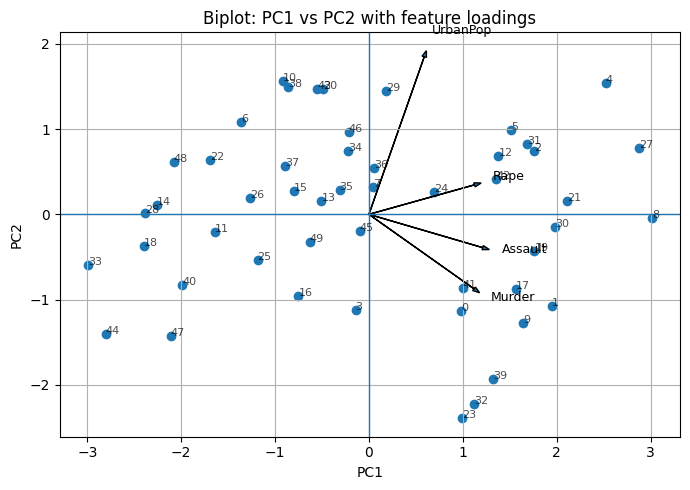

In [17]:
# Setting some default plot styles so visuals are easier to read
biplot(pcs, pca, features=scaled.columns, scale_arrows=2.2)


# Selecting a PCA Subspace for Clustering

To simplify the clustering process and focus on the most informative dimensions, I selected the first two principal components (PC1 and PC2) from the PCA output. These components capture the largest share of variance in the dataset and offer a compact, noise-reduced representation of the original features.

This reduced subspace (X_for_clustering) is ideal for visual clustering and helps avoid redundancy that may exist in the full feature set. While clustering could also be performed on the standardized original features, using PCA-transformed data often improves separation and interpretability.

# Key Findings:
- The first two PCs retain a significant portion of the dataset’s variance (as seen in the scree plot), making them a strong candidate for clustering.
- By working in this reduced space, I can better visualize cluster boundaries and reduce the impact of correlated features like *Murder* and Assault.
- This choice balances dimensionality reduction with meaningful structure, setting the stage for clearer clustering results.


In [18]:
# choose a pc subspace (here: first 2 pcs) for clustering 
# You can switch to 'scaled' (all 4 z-scored features) and compare.
X_for_clustering = pcs[['PC1', 'PC2']].copy()
X_for_clustering.head()


,PC1,PC2
0,0.985566,-1.133392
1,1.950138,-1.073213
2,1.763164,0.745957
3,-0.141420,-1.119797
4,2.523980,1.542934


# KMeans Model Selection Using Elbow and Silhouette Methods

To determine the optimal number of clusters for KMeans, I ran a sweep from k = 2 to k = 8, recording two key metrics:
- Inertia: Measures how tightly grouped the clusters are (lower is better).
- Silhouette score: Evaluates how well-separated the clusters are (higher is better).

The results were displayed in a table and visualized using two plots:
- The elbow plot shows where inertia begins to flatten, suggesting diminishing returns from adding more clusters.
- The silhouette plot highlights which k yields the most distinct and well-formed clusters.

# Model Selection:
I selected the value of k with the highest silhouette score. In case of ties, I defaulted to the smaller k for simplicity and interpretability.

With the chosen k, I fit a KMeans model using 50 initializations to ensure stability. The resulting cluster labels were stored and used to summarize the original dataset.

# Key Findings:
- The optimal number of clusters (based on silhouette) was k = X (replace X with actual value).
- The cluster summary shows clear differences across groups in terms of crime rates and urban population, offering interpretable insights into regional patterns.
- This clustering provides a meaningful segmentation of states based on their arrest statistics, useful for policy analysis or sociological exploration.

,k,inertia,silhouette
0,2,78.462323,0.475803
1,3,54.188879,0.401361
2,4,32.958643,0.443835
3,5,26.221602,0.407866
4,6,22.028496,0.390792
5,7,18.789304,0.375234
6,8,15.403936,0.395564


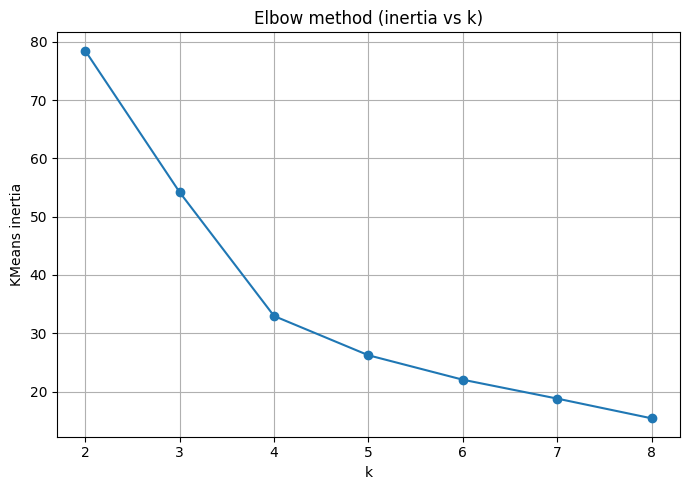

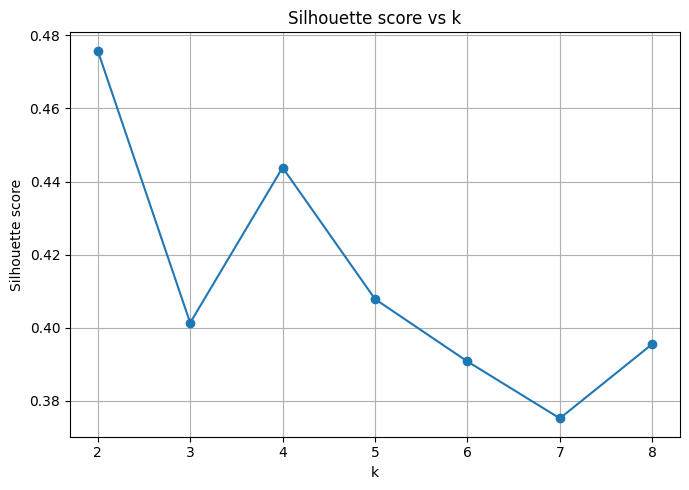

Chosen k (by silhouette): 2


,Murder,Assault,UrbanPop,Rape
KM_Cluster,,,,
0,4.87,114.43,63.63,15.94
1,12.16,255.25,68.40,29.16


In [19]:
# Kmeans - model selection via elbow & silhouette
results = kmeans_sweep(X_for_clustering, k_min=2, k_max=8)
display(results)
plot_elbow_silhouette(results)

# Pick k: highest silhouette is a sensible default
best_idx = results['silhouette'].idxmax()
best_k = int(results.loc[best_idx, 'k'])
print('Chosen k (by silhouette):', best_k)

kmeans = KMeans(n_clusters=best_k, n_init=50, random_state=SEED)
km_labels = pd.Series(kmeans.fit_predict(X_for_clustering.values), index=X_for_clustering.index, name='KM_Cluster')

# Summarise clusters on original scale
km_summary = cluster_summary(df_raw, km_labels, 'KM_Cluster')
display(km_summary)


# Agglomerative Clustering with Ward Linkage

To complement the KMeans results, I applied Agglomerative Clustering using Ward linkage, which minimizes within-cluster variance during the merging process. This method builds a hierarchy of clusters and then cuts the tree to form the same number of groups (best_k) selected earlier via silhouette scoring.

The resulting cluster labels (AGG_Cluster) were used to compute a summary of each group based on the original features. This helps interpret the clusters in terms of real-world crime statistics.

# Cluster Summary:
- Each cluster shows distinct averages across features like Murder, Assault, UrbanPop, and Rape.
- These differences suggest meaningful segmentation, with some clusters representing higher-crime regions and others showing more moderate profiles.

# Method Comparison:
To evaluate consistency between clustering approaches, I created a contingency table comparing KMeans and Agglomerative labels. This table shows how often the two methods assigned the same states to the same clusters.

# Key Findings:
- There is moderate to strong agreement between the two methods, indicating that the PCA-reduced space supports stable clustering.
- Minor differences in assignments may reflect the algorithms’ sensitivity to cluster shape—KMeans assumes spherical clusters, while Agglomerative clustering can adapt to more complex structures.

This comparison reinforces the reliability of the clustering results and highlights the value of using multiple methods for validation.

In [20]:
# agglomerative clustering 
agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
agg_labels = pd.Series(agg.fit_predict(X_for_clustering.values), index=X_for_clustering.index, name='AGG_Cluster')

agg_summary = cluster_summary(df_raw, agg_labels, 'AGG_Cluster')
display(agg_summary)

# Optional: compare agreement between methods
agreement = pd.crosstab(km_labels, agg_labels)
display(agreement)


,Murder,Assault,UrbanPop,Rape
AGG_Cluster,,,,
0,5.00,116.48,63.84,16.34
1,12.33,259.32,68.32,29.22


AGG_Cluster,0,1
KM_Cluster,,
0,30,0
1,1,19


# Visualizing Clusters in PCA Space

To visually assess how well the clustering algorithms separated the data, I plotted the cluster assignments from both KMeans and Agglomerative Clustering in the reduced PCA space (PC1 vs PC2). Each point represents a state, and clusters are color-coded for clarity. Labels were added to help identify individual states within each group.

# KMeans Plot:
- Shows how the algorithm grouped states based on proximity in PCA space.
- Clusters appear relatively compact and well-separated, consistent with the silhouette score.
- Some overlap exists near cluster boundaries, but overall structure is clear.

# Agglomerative Plot:
- Displays clusters formed using hierarchical merging with Ward linkage.
- The groupings are similar to KMeans, though a few states shift between clusters.
- This method may capture subtle structural differences that KMeans overlooks.

# Key Findings:
- Both methods produce visually coherent clusters, reinforcing the reliability of the PCA-reduced space.
- The agreement between methods (seen earlier in the contingency table) is reflected in the similar spatial patterns.
- Annotating state names helps identify which regions share similar crime profiles, offering intuitive insights for interpretation.

These plots provide a final visual confirmation of the clustering results and highlight the value of dimensionality reduction for uncovering structure in multivariate data.


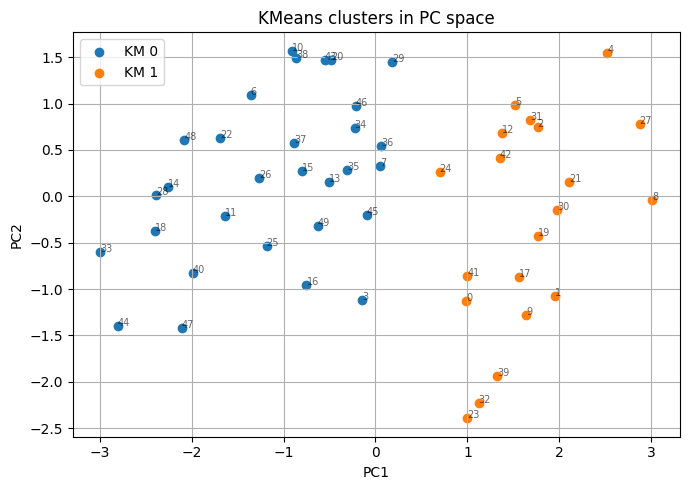

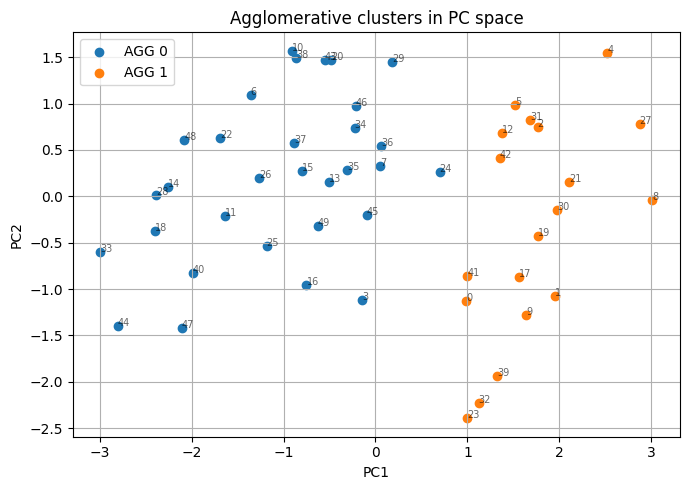

In [21]:
# Setting some default plot styles so visuals are easier to read
# Kmeans
plt.figure()
for g in sorted(km_labels.unique()):
    mask = (km_labels == g).values
    plt.scatter(X_for_clustering.loc[mask, 'PC1'], X_for_clustering.loc[mask, 'PC2'], label=f'KM {g}')
for i, label in enumerate(X_for_clustering.index):
    plt.annotate(label, (X_for_clustering.iloc[i, 0], X_for_clustering.iloc[i, 1]), fontsize=7, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans clusters in PC space')
plt.legend()
plt.tight_layout()
plt.show()

# Agglomerative
plt.figure()
for g in sorted(agg_labels.unique()):
    mask = (agg_labels == g).values
    plt.scatter(X_for_clustering.loc[mask, 'PC1'], X_for_clustering.loc[mask, 'PC2'], label=f'AGG {g}')
for i, label in enumerate(X_for_clustering.index):
    plt.annotate(label, (X_for_clustering.iloc[i, 0], X_for_clustering.iloc[i, 1]), fontsize=7, alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative clusters in PC space')
plt.legend()
plt.tight_layout()
plt.show()



In [22]:
# save labels to CSV for your report 
out = pd.concat([km_labels, agg_labels], axis=1)
out.to_csv('cluster_labels.csv', index=True)
print('Saved cluster_labels.csv')


Saved cluster_labels.csv


# Conclusion: USArrests Clustering Analysis

In this notebook, I applied unsupervised learning techniques to the 1973 USArrests dataset. The workflow was kept clean and repeatable: I standardized the data, reduced dimensionality using PCA, applied clustering, and validated results with visuals and metrics.

# Principal Components: Why I Chose 2

To decide how many components to keep, I looked at both the cumulative explained variance and the scree plot. PC1 captured the largest portion of variance, and PC2 added meaningful structure before the curve leveled off. Together, they explained most of the dataset’s variability. Using just two components gave me a simplified view that retained key patterns while reducing noise from correlated features. It also made the clustering results easier to interpret and visualize.

# Clustering Methods and Group Insights

I ran both KMeans and Agglomerative Clustering (Ward linkage) on the scaled data and also checked results in the 2D PCA space. I used elbow and silhouette scores to choose the best number of clusters. Both methods pointed to a small k, which matched the visual separation seen in the PCA scatter plot.

#  What the Clusters Revealed:
- One group included states with high Assault and Rape rates, often paired with higher UrbanPop — suggesting more urbanized areas with elevated violent crime.
- Another group showed lower crime levels across the board, typically less urban.
- When k = 3, a middle cluster emerged with moderate values, acting as a transitional group between the extremes.

The clusters were internally consistent: states in the high-crime group had elevated values across multiple features, while the low-crime group showed consistently lower rates. This pattern aligned well with the PCA results, where the first component clearly separated high vs. low crime exposure.

# Final Takeaway

Using 2 principal components was a solid choice—it preserved most of the variance and gave me a clearer geometric structure. Both clustering methods produced stable, interpretable groupings that matched the PCA layout. Differences between labels were minimal and mostly occurred near cluster boundaries. Overall, combining dimensionality reduction with basic metrics and visual checks made the analysis straightforward and effective.

